In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if (device=='cpu'):
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

cuda:0
CUDA is available!  Training on GPU ...


In [2]:
### Imagenes entre  -1 y 1....luego
#data 2 igual a mi data satelital

## Dataset import

In [3]:
#come
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from transformsdata import (DualCompose,
                        ImageOnly,
                        Normalize,
                        HorizontalFlip,
                        Rotate,
                        CenterCrop,
                        VerticalFlip)
from torch.utils.data import Dataset
from pathlib import Path
import numpy as np
import cv2



batch_size=4


class imagenDataset(Dataset): #leo 1 img, transform, to tensor
    def __init__(self,  img_paths: list,  transform=None, mode= 'train', limit=None):
        self.img_paths =   img_paths
        self.transform = transform
        self.mode= mode
        self.limit = limit
        
    def __len__(self):
        if self.limit is None:
            return len(self.img_paths)
        else:
            return self.limit        #limite????
    
    def __getitem__(self, idx):    
        #cargar una imagen
        if self.limit is None:
            img_file_name = self.img_paths[idx]
            #print('name image in', img_file_name)

        else:
            img_file_name = np.random.choice(self.img_paths)
        
        img = load_image(img_file_name)   #imagen RGB
        #print('one image out', img.shape)
        
        #cargar una mascara
        if self.mode == 'train':
               
            mask = load_mask(img_file_name)   #la mascara
            #print('mask image', img_file_name)
            #print('mask image', mask.shape)
            img, mask = self.transform(img, mask)    #cargo la img y transformo   
            #print(mask.shape)
            return to_float_tensor(img),  torch.from_numpy(np.expand_dims(mask, 0)).float()
            
        else:
            mask = np.zeros(img.shape[:2]) #no se tiene la data =>  zeros
            img, mask = self.transform(img, mask)
            return to_float_tensor(img), str(img_file_name)
            


def load_image(path):
    img = np.load(str(path)) # 
    img=img.transpose((1, 2, 0)) 
    #print('one image in', img.shape)
    return  img 

def load_mask(path):   
    mask= np.zeros((512, 512))
    mask = np.load(str(path).replace('images', 'masks').replace(r'.npy', r'_a.npy'), 0)
    #print('one mask in ant T', mask.shape)
    mask=mask.transpose(1, 2, 0).reshape(512,-1)
    mask=(mask > 0).astype(np.uint8)
    #print('before the mask',mask.shape)
    return mask#boolean a float    dtype

# swap color axis because
# numpy image: H x W x C
# torch image: C X H X W   

def to_float_tensor(img):#(512, 512, 3)
    #print('img_tensor',img.shape)
    #print('img_tensor-to tensor bedore',img.shape)
    img=torch.from_numpy(np.moveaxis(img, -1, 0)).float()  #2,0,1 torch.Size([3, 512, 512]) convert to tensory change channels
    #print('img_tensor',img.shape) 
    return img 

In [4]:
data_path = Path('data')
train_path= data_path/'train'/'images'
val_path= data_path/'val'/'images'

train_file_names = np.array(sorted(list(train_path.glob('*.npy'))))
print(len(train_file_names))
val_file_names = np.array(sorted(list(val_path.glob('*.npy'))))
print(len(val_file_names))

792
31


In [5]:
#mask_path=data_path/'train'/'masks'
#train_file_names = np.array(sorted(list(mask_path.glob('*.jpg'))))

#for filename in train_file_names:
    #print((str(filename)))
   # img = cv2.imread(str(filename))
    #print (img.shape)



## Dataloader

In [6]:
def make_loader(file_names, shuffle=False, transform=None, limit=None):
    return DataLoader(
            dataset=imagenDataset(file_names, transform=transform, limit=limit),
            shuffle=shuffle,
            batch_size=batch_size
        )

                      
train_transform = DualCompose([
        CenterCrop(512),
        HorizontalFlip(),
        VerticalFlip(),
        Rotate(),
        ImageOnly(Normalize())
    ])

val_transform = DualCompose([
        CenterCrop(512),
        ImageOnly(Normalize())
    ])

train_loader = make_loader(train_file_names, shuffle=True, transform=train_transform)
#why false shuffle sale error
valid_loader = make_loader(val_file_names, transform=val_transform)
    
    
dataloaders = {
    'train': train_loader, 'val': valid_loader
}

dataloaders_sizes = {
    x: len(dataloaders[x]) for x in dataloaders.keys()
}

dataloaders_sizes 

{'train': 198, 'val': 8}

In [7]:
img,labels=next(iter(train_loader)) 
print(img[1].shape)
print(labels[1].shape)

torch.Size([4, 512, 512])
torch.Size([1, 512, 512])


In [8]:
#img,labels=next(iter(valid_loader)) #tensor Chanelsx HxW #
#print('imgsize',img.shape)
#img = img.transpose((2, 0, 1))  
#img=torch.from_numpy(np.moveaxis(img, -1, 0)).float() #convert to tensor
#print('masksize',lab.shape)

In [9]:
#for images, labels in  dataloaders['train']:
#    img = images
#    lab = labels

In [10]:
#    img = images
#    lab = labels

#img,labels=next(iter(train_loader)) 
#print(img)
#img,labels=next(iter(train_loader)) #tensor Chanelsx HxW 
    #print('imgsize',img.shape)
    #img = img.transpose((2, 0, 1))  
#img=torch.from_numpy(np.moveaxis(img, -1, 0)).float() #convert to tensor

   
    #print('masksize',lab.shape)

In [11]:
import torchvision.utils
import matplotlib.pyplot as plt

def reverse_transform(inp):   
    inp = inp.numpy().transpose((1, 2, 0))  # chanel 0 sizx 1 sizy 2 => sizx1  sizy2 chanel 0
    inp = np.clip(inp, 0, 1)
    inp = (inp*3413).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))#tensor  CXHXW

print('batch',inputs.shape, masks.shape)

for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())


plt.imshow(reverse_transform(inputs[3,:3,:,:]))
plt.show()

inp=reverse_transform(inputs[3,:3,:,:]/3413)


print(inp.shape)


batch torch.Size([4, 4, 512, 512]) torch.Size([4, 1, 512, 512])
-1.0934892 14.131211 0.53002936 0.69422317
0.0 1.0 0.019629478 0.13872324


<Figure size 640x480 with 1 Axes>

(512, 512, 3)


In [12]:
import torchvision.utils
import matplotlib.pyplot as plt

def reverse_transform2(inp): 
    inp = inp.to('cpu').numpy().transpose((1, 2, 0))
    mean = np.array([0.25864499, 0.26125361, 0.33177851])
    std = np.array([0.20740983, 0.16791244, 0.20853833])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp).astype(np.float32)

    return inp

torch.Size([4, 4, 512, 512]) torch.Size([4, 1, 512, 512])
-1.1556712 4.677917 0.46873885 0.9609562
0.0 1.0 0.32289314 0.4675823
0.034988813 0.23824997 0.10053426 0.041862957


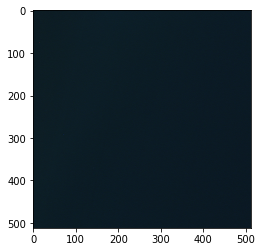

In [13]:

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))#tensor  CXHXW

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

img_revers=reverse_transform2(inputs[3,:3,:,:])
print(img_revers.min(), img_revers.max(),img_revers.mean(), img_revers.std())                              
plt.imshow(img_revers)

## Model

In [14]:
import os,sys
from torchsummary import summary
import torch
import torch.nn as nn
import pytorch_unet
import models
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = models.UNet11(6)
model = model.to(device)

summary(model, input_size=(4,512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           2,304
              ReLU-2         [-1, 64, 512, 512]               0
              ReLU-3         [-1, 64, 512, 512]               0
              ReLU-4         [-1, 64, 512, 512]               0
              ReLU-5         [-1, 64, 512, 512]               0
              ReLU-6         [-1, 64, 512, 512]               0
              ReLU-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,856
           Conv2d-10        [-1, 128, 256, 256]          73,856
             ReLU-11        [-1, 128, 256, 256]               0
             ReLU-12        [-1, 128, 256, 256]               0
             ReLU-13        [-1, 128, 256, 256]               0
             ReLU-14        [-1, 128, 2

/home/jgonzalez/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


## Train + metrics

In [15]:
from collections import defaultdict
import torch.nn.functional as F
import loss
from loss import dice_loss, metric_jaccard,metric_dice

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred) #!!!!!
    dice = dice_loss(pred, target)
    
    pred2=(pred >0).float()  #!!!!!!
    dice_m= metric_dice(pred2, target)
    jaccard_m=metric_jaccard(pred2, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)

    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['diceloss'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    metrics['result_jaccard']+= jaccard_m.data.cpu().numpy() * target.size(0)
    metrics['result_dice'] += dice_m.data.cpu().numpy() * target.size(0)
    
    
    return loss

def print_metrics(metrics, epoch_samples, phase): # print by epoch
    outputs = []
    for k in metrics.keys():       #metricas(frist-mean-input.size)samples
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                #print(inputs.shape, labels.shape)
    
    
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics) #criterion

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0) # ctd of samples in a batch

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Train Model

In [16]:
#data me

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import models
#import ternausnet2

#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1

#model = models.TernausNetV2(num_classes).to(device)
model = models.UNet11(num_class).to(device)
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1) #25

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=5)

cuda:0
Epoch 0/4
----------
LR 0.0001


/home/jgonzalez/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.187244, diceloss: 0.445563, loss: 0.316404, result_jaccard: 0.455750, result_dice: 0.496919
val: bce: 0.041347, diceloss: 0.707203, loss: 0.374275, result_jaccard: 0.093892, result_dice: 0.126201
saving best model
1m 31s
Epoch 1/4
----------
LR 0.0001
train: bce: 0.104422, diceloss: 0.403631, loss: 0.254027, result_jaccard: 0.455100, result_dice: 0.495912
val: bce: 0.033620, diceloss: 0.702098, loss: 0.367859, result_jaccard: 0.093892, result_dice: 0.126201
saving best model
1m 32s
Epoch 2/4
----------
LR 0.0001
train: bce: 0.131941, diceloss: 0.350941, loss: 0.241441, result_jaccard: 0.455937, result_dice: 0.497070
val: bce: 0.040969, diceloss: 0.305018, loss: 0.172994, result_jaccard: 0.093892, result_dice: 0.126201
saving best model
1m 32s
Epoch 3/4
----------
LR 0.0001
train: bce: 0.130114, diceloss: 0.286053, loss: 0.208084, result_jaccard: 0.457644, result_dice: 0.500041
val: bce: 0.056474, diceloss: 0.234290, loss: 0.145382, result_jaccard: 0.135799, result_dice: 0

# ok

## Save model

In [17]:
torch.save(model.state_dict(),'modelwithoutblack5epoch.pth') 

# Prediction

In [47]:
import math
import helper
model.eval()   # Set model to evaluate mode

data_path = Path('data')
test_path= data_path/'val'/'images' ###cambiar a test3
test_file_names = np.array(sorted(list(test_path.glob('*.npy'))))


test_loader = make_loader(test_file_names, shuffle=True, transform=val_transform)

        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(inputs.shape)
print(pred.shape)

torch.Size([4, 4, 512, 512])
(4, 1, 512, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 512, 512, 3)


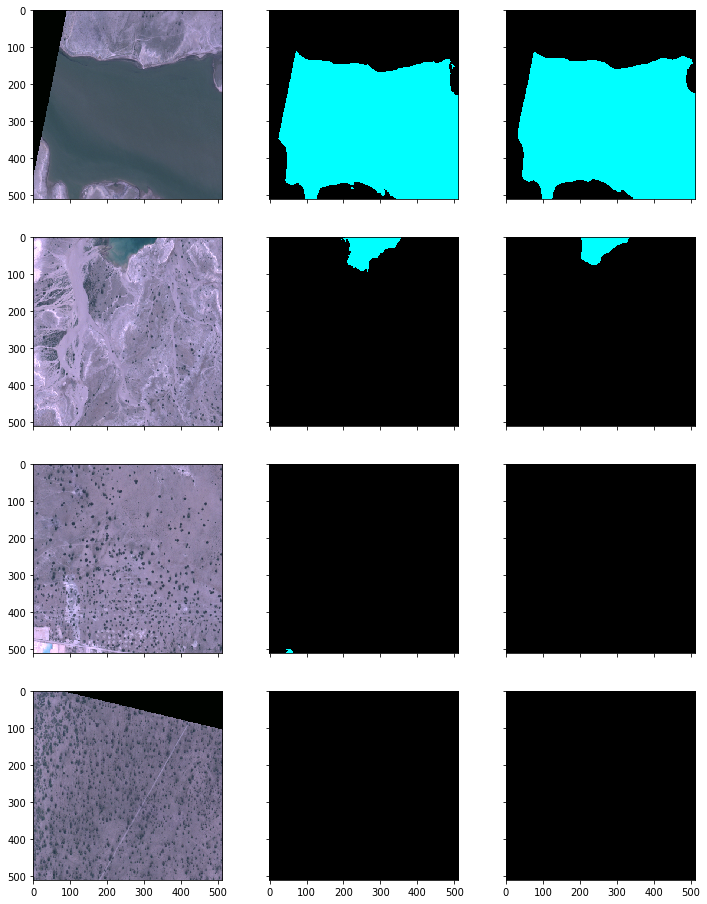

In [55]:
import helper

input_images_rgb = [reverse_transform2(x) for x in inputs[:,:3,:,:].cpu()]
# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]
print(np.shape(input_images_rgb))
helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [40]:
!python train.py --device-ids 0 --fold 1 --limit 100 --batch-size 4 --n-epochs 100 --model UNet


  File "train.py", line 58
    else:
       ^
SyntaxError: invalid syntax
